# Lab 2

### Part 0: The helper function

In [18]:
from abc import abstractmethod, ABC
from typing import Optional, List, Type, Tuple, Dict
import math
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import seaborn as sns
from sklearn.datasets import make_moons, make_circles

import torch
import torch.distributions as D
from torch.func import vmap, jacrev

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Import all packages successfully\nAnd the device is: {device}")

Import all packages successfully
And the device is: cuda


In [19]:
class Sampleable(ABC):
    # Distributions that can be sampled from

    @property
    @abstractmethod
    def dim(self) -> int:
        # Return the dimensitons of the distributions
        pass

    @abstractmethod
    def sample(self, num_samples: int) -> torch.Tensor:
        # Returns: shape(batch_size, dim)
        pass

class Density(ABC):
    # Distributions with tractable density

    @abstractmethod
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        """ 
        Returns the log density of x
        x: shape(batch_size, dim), log_density: shape(batch_size, 1) 
        """
        pass

class Gaussian(torch.nn.Module, Sampleable, Density):
    # Multivariate Gaussian Distributions

    def __init__(self, mean: torch.Tensor, cov: torch.Tensor):
        # mean: shape(dim,), cov: shape(dim, dim)
        super().__init__()
        self.register_buffer("mean", mean)
        self.register_buffer("cov", cov)

    @property
    def dim(self) -> int:
        return self.mean.shape[0]
    
    @property
    def distribution(self):
        return D.MultivariateNormal(self.mean, self.cov, validate_args = False)
    
    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample((num_samples, ))

    def log_density(self, x: torch.Tensor):
        return self.distribution.log_prob(x).view(-1, 1) 
    
    @classmethod
    def isotropic(cls, dim: int, std: float) -> "Gaussian":
        mean = torch.zeros(dim)
        cov = torch.eye(dim) * std ** 2
        return cls(mean, cov)
    
class GaussianMixture(torch.nn.Module, Sampleable, Density):
    # 2-D Gaussian mixture model, and a Density and a Sampleable.
    # Wrap around torch.distributions.MixtureSameFamily

    def __init__(
        self,
        means: torch.Tensor,        # nmodes * data_dim
        covs: torch.Tensor,         # nomdes * data_dim * data_dim
        weights: torch.Tensor        # nmode
    ):
        super().__init__()
        self.nmodes = means.shape[0]
        self.register_buffer("means", means)
        self.register_buffer("covs", covs)
        self.register_buffer("weights", weights)

    @property
    def dim(self) -> int:
        return self.means.shape[1]
    
    @property
    def distribution(self):
        return D.MixtureSameFamily(
                mixture_distribution=D.Categorical(probs=self.weights, validate_args=False),
                component_distribution=D.MultivariateNormal(
                    loc=self.means,
                    covariance_matrix=self.covs,
                    validate_args=False,
                ),
                validate_args=False,
            )
    
    def log_density(self, x: torch.Tensor) -> torch.Tensor:
        return self.distribution.log_prob(x).view(-1, 1)

    def sample(self, num_samples: int) -> torch.Tensor:
        return self.distribution.sample(torch.Size((num_samples, )))
    
    @classmethod
    def random_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0, seed = 0.0 
    ) -> "GaussianMixture":
        torch.manual_seed(seed)
        means = (torch.rand(nmodes, 2) - 0.5) * scale + x_offset * torch.Tensor([1.0, 0.0]) 
        covs = torch.diag_embed(torch.ones(nmodes, 2)) * std ** 2
        weights = torch.ones(nmodes)
        return cls(means, covs, weights)
    
    @classmethod
    def symmetric_2D(
        cls, nmodes: int, std: float, scale: float = 10.0, x_offset: float = 0.0
    ) -> "GaussianMixture":
        angles = torch.linspace(0, 2 * np.pi, nmodes + 1) [: nmodes]
        means = torch.stack([torch.cos(angles), torch.sin(angles)], dim = 1) * scale + torch.Tensor([1.0, 0.0]) * x_offset
        covs = torch.diag_embed(torch.ones(nmodes, 2) * std ** 2)
        weights = torch.ones(nmodes) / nmodes
        return cls(means, covs, weights)

In [20]:
# Several plotting utility functions
def hist2d_samples(samples, ax: Optional[Axes] = None, bins: int = 200, scale: float = 5.0, percentile: int = 99, **kwargs):
    """
    Plot a 2D histogram (density heatmap) from raw sample points.
    - samples: Tensor of shape (n, 2)
    - ax: target matplotlib axis (optional)
    - bins: number of bins in each dimension
    - scale: sets the visible range [-scale, scale]
    - percentile: for clipping the color scale (removes outlier effects)
    """
    H, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=bins, range=[[-scale, scale], [-scale, scale]])

    # Determine color normalization based on the 99th percentile
    cmax = np.percentile(H, percentile)
    cmin = 0.0
    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    
    # Plot using imshow for more control
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(H.T, extent=extent, origin='lower', norm=norm, **kwargs)

def hist2d_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, bins=200, scale: float = 5.0, percentile: int = 99, **kwargs):
    """
    Sample from a Sampleable distribution and plot its 2D histogram.
    This wraps hist2d_samples to work directly with distribution objects.
    """
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples).detach().cpu() # (ns, 2)
    hist2d_samples(samples, ax, bins, scale, percentile, **kwargs)

def scatter_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    """
    Sample from a Sampleable distribution and show a scatter plot of points.
    Useful for visualizing the structure of the sample cloud.
    """
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    ax.scatter(samples[:,0].cpu(), samples[:,1].cpu(), **kwargs)

def kdeplot_sampleable(sampleable: Sampleable, num_samples: int, ax: Optional[Axes] = None, **kwargs):
    """
    Sample from a Sampleable distribution and apply kernel density estimation (KDE).
    This produces smooth contours, using seaborn.
    """
    assert sampleable.dim == 2
    if ax is None:
        ax = plt.gca()
    samples = sampleable.sample(num_samples) # (ns, 2)
    sns.kdeplot(x=samples[:,0].cpu(), y=samples[:,1].cpu(), ax=ax, **kwargs)

def imshow_density(density: Density, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], bins: int, ax: Optional[Axes] = None, x_offset: float = 0.0, **kwargs):
    """
    Evaluate the log-density of a 2D distribution on a grid and show it as an image.
    - density: a Density-compatible object (implements .log_density)
    - x_bounds, y_bounds: bounding box for the grid
    - bins: resolution of the grid
    """
    if ax is None:
        ax = plt.gca()
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds
    x = torch.linspace(x_min, x_max, bins).to(device) + x_offset
    y = torch.linspace(y_min, y_max, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.imshow(density.cpu(), extent=[x_min, x_max, y_min, y_max], origin='lower', **kwargs)

def contour_density(density: Density, bins: int, scale: float, ax: Optional[Axes] = None, x_offset:float = 0.0, **kwargs):
    """
    Plot contour lines of the log-density over a 2D grid.
    Similar to imshow_density, but using contour curves instead of heatmap.
    """
    if ax is None:
        ax = plt.gca()
    x = torch.linspace(-scale + x_offset, scale + x_offset, bins).to(device)
    y = torch.linspace(-scale, scale, bins).to(device)
    X, Y = torch.meshgrid(x, y)
    xy = torch.stack([X.reshape(-1), Y.reshape(-1)], dim=-1)
    density = density.log_density(xy).reshape(bins, bins).T
    im = ax.contour(density.cpu(), origin='lower', **kwargs)

In [21]:
class ODE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # xt: shape(batch_size, dim), t: shape(batch_size, 1), drift_coefficient: shape(batch_size, dim)
        # The velocity at (xt, t)
        pass

class SDE(ABC):
    @abstractmethod
    def drift_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # xt: shape(batch_size, dim), t: shape(batch_size, 1), drift_coefficient: shape(batch_size, dim)
        pass

    @abstractmethod
    def diffusion_coefficient(self, xt: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # xt: shape(batch_size, dim), t: shape(batch_size, 1), diffusion_coefficient: shape(batch_size, dim)
        pass

In [22]:
class Simulator(ABC):
    @abstractmethod
    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor) -> torch.Tensor:
        # xt: shape(batch_size, dim), t: shape(bathc_size, 1), dt: shape(batch_size, 1), step: shape(batch_size, dim)
        # to update the state at t to state at t + dt
        pass

    @torch.no_grad
    def simulate(self, x: torch.Tensor, ts: torch.Tensor):
        # x_init: shape(batch_size, dim), ts: shape(batch_size, num_steps, 1), x_final: shape(batch_size, dim)
        # x_init: the state at ts[:, 0], x_final: state at ts[:, -1]
        for time_index in range(ts.shape[0] - 1):
            t = ts[:, time_index]
            h = ts[:, time_index + 1] - ts[:, time_index]
            x = self.step(x, t, h)
        return x
    
    @torch.no_grad
    def simulate_with_trajectory(self, x: torch.Tensor, ts: torch.Tensor):
        # x_init: shape(batch_size, dim), ts: shape(batch_size, num_steps, 1), returns: shape(batch_size, num_steps, dim)
        # x_init: the state at ts[:, 0], return: the trajectory of all tensors
        trajectories = [x.clone()]
        for time_index in range(ts.shape[1] - 1):
            t = ts[:, time_index]
            h = ts[:, time_index + 1] - ts[:, time_index]
            x = self.step(x, t, h)
            trajectories.append(x.clone())
        return torch.stack(trajectories, dim = 1)
    
class EulerSimulator(Simulator):
    def __init__(self, ode: ODE):
        self.ode = ode

    def step(self, xt: torch.Tensor, t: torch.Tensor, dt: torch.Tensor) -> torch.Tensor:
        # See the definition of Simulator class for detials
        return xt + self.ode.drift_coefficient(xt, t) * dt

class EulerMaruyamaSimulator(Simulator):
    def __init__(self, sde: SDE):
        self.sde = sde
        
    def step(self, xt: torch.Tensor, t: torch.Tensor, h: torch.Tensor):
        return xt + self.sde.drift_coefficient(xt,t) * h + self.sde.diffusion_coefficient(xt,t) * torch.sqrt(h) * torch.randn_like(xt)
    
def record_every(num_timesteps: int, record_every: int) -> torch.Tensor:
    """
    Compute the indices to record in the trajectory given a record_every parameter
    """
    if record_every == 1:
        return torch.arange(num_timesteps)
    return torch.cat(
        [
            torch.arange(0, num_timesteps - 1, record_every),
            torch.tensor([num_timesteps - 1]),
        ]
    )


### Part 1: Define the Conditional Probability Path
Here, we mainly cover the Gaussian Conditional Probability Path and the Linear Conditional Probability Path

In [23]:
class ConditionalProbabilityPath(torch.nn.Module, ABC):
    """
    Abstract base class for conditional probability paths
    """
    def __init__(self, p_simple: Sampleable, p_data: Sampleable):
        super().__init__()
        self.p_simple = p_simple
        self.p_data = p_data

    def sample_marginal_path(self, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the marginal distribution p_t(x) = p_t(x|z) p(z)
        Args:
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x), (num_samples, dim)
        """
        num_samples = t.shape[0]
        # Sample conditioning variable z ~ p(z)
        z = self.sample_conditioning_variable(num_samples) # (num_samples, dim)
        # Sample conditional probability path x ~ p_t(x|z)
        x = self.sample_conditional_path(z, t) # (num_samples, dim)
        return x

    @abstractmethod
    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        """
        Samples the conditioning variable z
        Args:
            - num_samples: the number of samples
        Returns:
            - z: samples from p(z), (num_samples, dim)
        """
        pass
    
    @abstractmethod
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Samples from the conditional distribution p_t(x|z)
        Args:
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - x: samples from p_t(x|z), (num_samples, dim)
        """
        pass
        
    @abstractmethod
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional vector field u_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_vector_field: conditional vector field (num_samples, dim)
        """ 
        pass

    @abstractmethod
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Evaluates the conditional score of p_t(x|z)
        Args:
            - x: position variable (num_samples, dim)
            - z: conditioning variable (num_samples, dim)
            - t: time (num_samples, 1)
        Returns:
            - conditional_score: conditional score (num_samples, dim)
        """ 
        pass

## Part 2: The Gaussian Conditional Probability Path

In [24]:
# Constants for the duration of our use of Gaussian conditional probability paths, to avoid polluting the namespace...
PARAMS = {
    "scale": 15.0,
    "target_scale": 10.0,
    "target_std": 1.0,
}

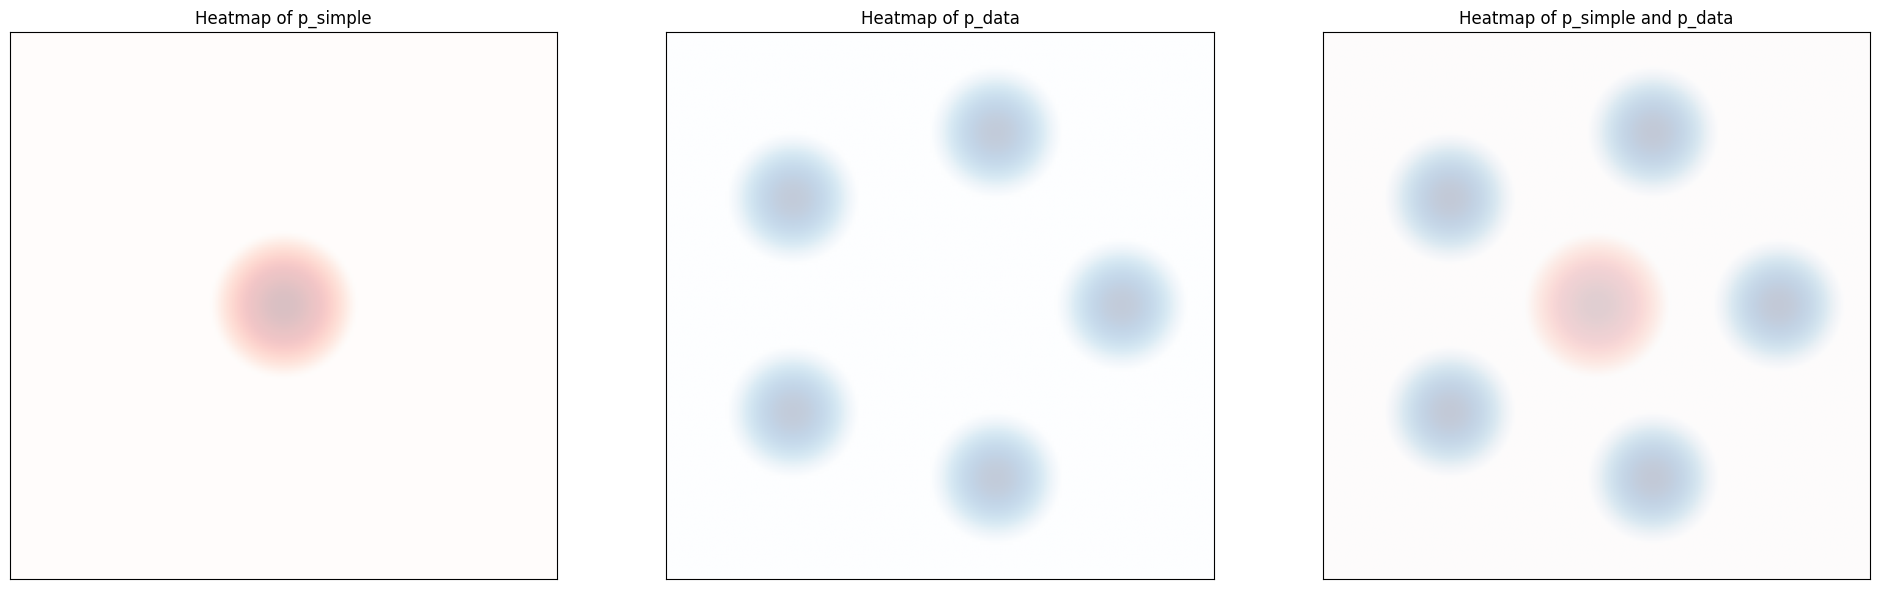

In [25]:
p_simple = Gaussian.isotropic(dim=2, std = 1.0).to(device)
p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device)

fig, axes = plt.subplots(1,3, figsize=(24,8))
bins = 200

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

axes[0].set_title('Heatmap of p_simple')
axes[0].set_xticks([])
axes[0].set_yticks([])
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[0], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))


axes[1].set_title('Heatmap of p_data')
axes[1].set_xticks([])
axes[1].set_yticks([])
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=axes[1], vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

axes[2].set_title('Heatmap of p_simple and p_data')
axes[2].set_xticks([])
axes[2].set_yticks([])
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

In [26]:
class Alpha(ABC):
    def __init__(self):
        assert torch.allclose(
            self(torch.zeros(1, 1)), torch.zeros(1, 1)
        )
        assert torch.allclose(
            self(torch.ones(1, 1)), torch.ones(1, 1)
        )
    
    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1), self(t): shape(num_samples, 1)
        # input a tuple of time, and output a tuple of alpha(t)
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        # t: shape(num_samples, 1),  d/d t \alpha(t): shape(num_samples, 1)
        # take the deravitive of t relatively
        t = t.unsqueeze(1)              # shape(num_samples, 1) -> shape(num_samples, 1, 1)
        dt = vmap(jacrev(self)) (t)     # 
        return dt.view(-1, 1)
    
class Beta(ABC):
    def __init__(self):
        assert torch.allclose(
            self(torch.zeros(1, 1)), torch.ones(1, 1)
        )
        assert torch.allclose(
            self(torch.ones(1, 1)), torch.zeros(1, 1)
        )

    @abstractmethod
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        # See the comments for alpha
        pass

    def dt(self, t: torch.Tensor) -> torch.Tensor:
        t = t.unsqueeze(1)
        dt = vmap(jacrev(self)) (t)
        return dt.view(-1, 1)

In [27]:
class LinearAlpha(Alpha):
    # alpha(t) = t
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return t
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return torch.ones_like(t)
    
class SquareRootBeta(Beta):
    # beta(t) = sqrt(1 - t)
    def __call__(self, t: torch.Tensor) -> torch.Tensor:
        return (1 - t).sqrt()
    
    def dt(self, t: torch.Tensor) -> torch.Tensor:
        return - 0.5 / (torch.sqrt(1 - t) + 1e-5)

In [28]:
class GaussianConditionalProbabilityPath(ConditionalProbabilityPath):
    def __init__(self, p_data: Sampleable, alpha: Alpha, beta: Beta):
        p_simple = Gaussian.isotropic(p_data.dim, 1.0)
        super().__init__(p_simple, p_data)
        self.alpha = alpha
        self.beta = beta

    def sample_conditioning_variable(self, num_samples: int) -> torch.Tensor:
        return self.p_data.sample(num_samples)
    
    def sample_conditional_path(self, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        return self.alpha(t) * z + self.beta(t) * torch.randn_like(z)
    
    def conditional_vector_field(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        dt_alpha_t = self.alpha.dt(t)
        dt_beta_t = self.beta.dt(t)

        return (dt_alpha_t - dt_beta_t / beta_t * alpha_t) * z + dt_beta_t / beta_t * x
    
    def conditional_score(self, x: torch.Tensor, z: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        alpha_t = self.alpha(t)
        beta_t = self.beta(t)
        return (z * alpha_t - x) / beta_t ** 2

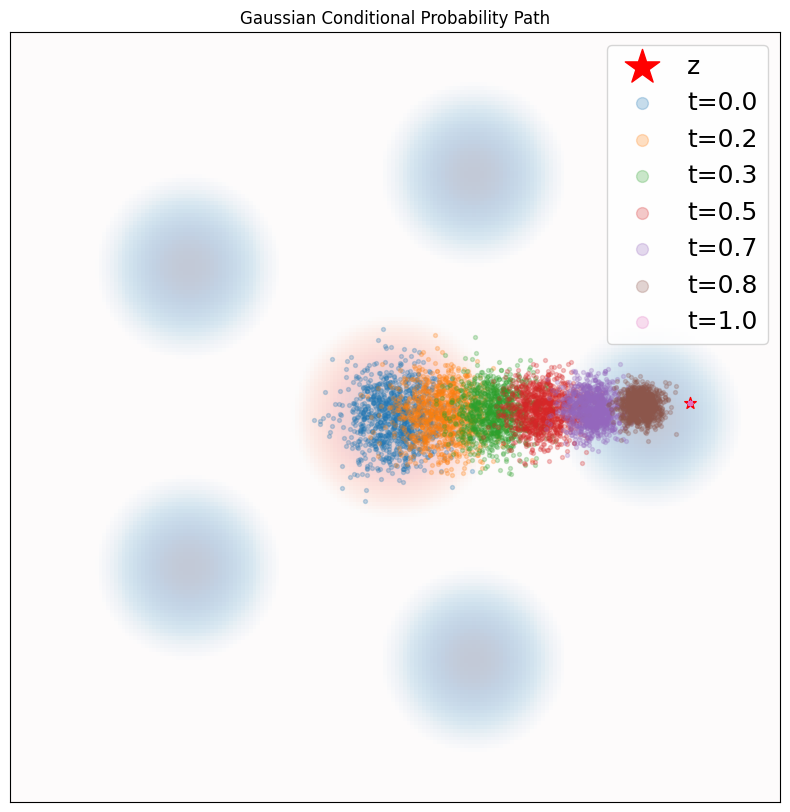

In [29]:
# Construct conditional probability path
path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device), 
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)

scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

plt.figure(figsize=(10,10))
plt.xlim(*x_bounds)
plt.ylim(*y_bounds)
plt.title('Gaussian Conditional Probability Path')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

# Sample conditioning variable z
z = path.sample_conditioning_variable(1) # (1,2)
ts = torch.linspace(0.0, 1.0, 7).to(device)

# Plot z
plt.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=75, label='z')
plt.xticks([])
plt.yticks([])

# Plot conditional probability path at each intermediate t
num_samples = 1000
for t in ts:
    zz = z.expand(num_samples, 2)
    tt = t.unsqueeze(0).expand(num_samples, 1) # (samples, 1)
    samples = path.sample_conditional_path(zz, tt) # (samples, 2)
    plt.scatter(samples[:,0].cpu(), samples[:,1].cpu(), alpha=0.25, s=8, label=f't={t.item():.1f}')

plt.legend(prop={'size': 18}, markerscale=3)
plt.show()

In [30]:
class ConditionalVectorFieldODE(ODE):
    def __init__(self, path: GaussianConditionalProbabilityPath, z: torch.Tensor):
        super().__init__()
        self.path = path
        self.z = z

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        batch_size = x.shape[0]
        z = self.z.expand(batch_size, *self.z.shape[1:])
        return self.path.conditional_vector_field(x, z, t)

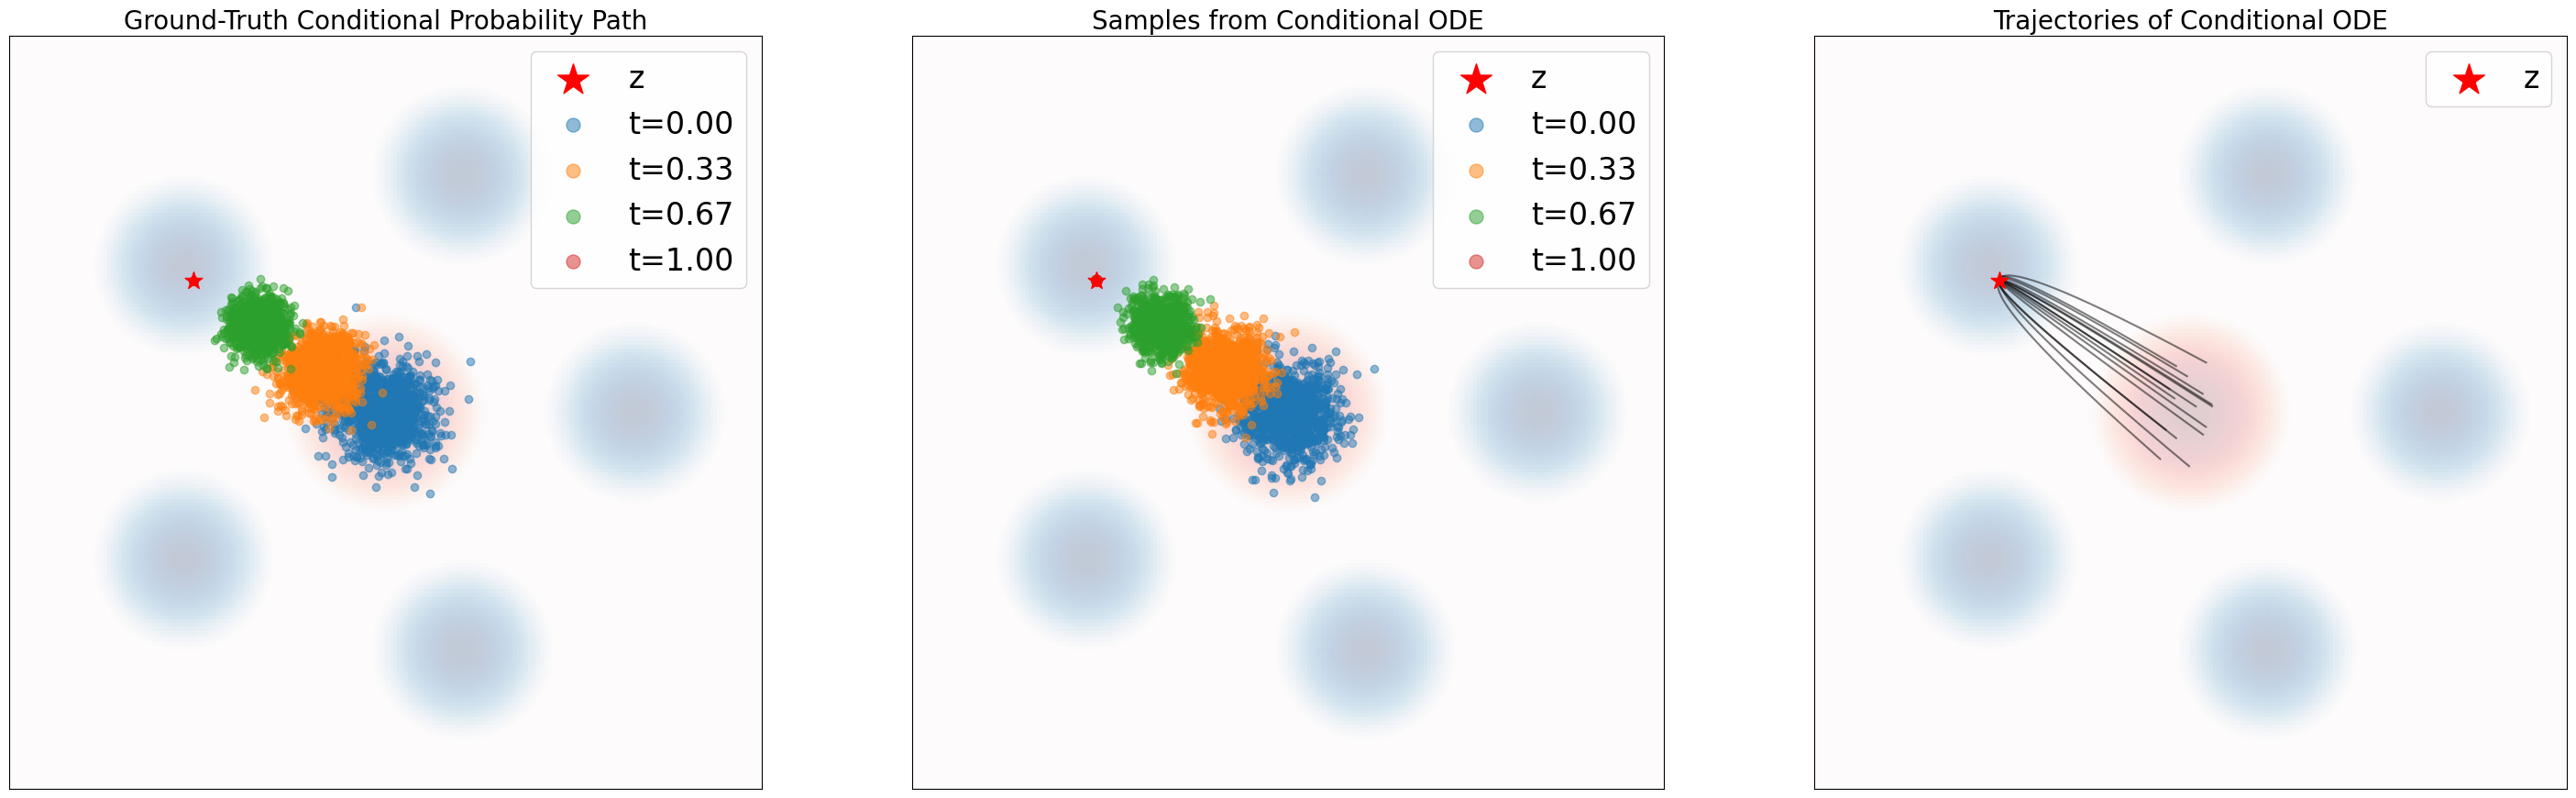

In [31]:
# Run me for Problem 2.3!

#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3

########################
# Setup path and plot  #
########################

path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device), 
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)


# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))
scale = PARAMS["scale"]
legend_size = 24
markerscale = 1.8
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]

# Sample conditioning variable z
torch.cuda.manual_seed(1)
z = path.sample_conditioning_variable(1) # (1,2)

######################################
# Graph samples from conditional ODE #
######################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Samples from Conditional ODE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
ode = ConditionalVectorFieldODE(path, z)
simulator = EulerSimulator(ode)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


#########################################
# Graph Trajectories of Conditional ODE #
#########################################
ax = axes[2]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Trajectories of Conditional ODE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(15):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


###################################################
# Graph Ground-Truth Conditional Probability Path #
###################################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground-Truth Conditional Probability Path', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    zz = z.expand(num_samples, 2)
    marginal_samples = path.sample_conditional_path(zz, tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

#### This is the SDE, and, I can simply omit it.

In [32]:
class ConditionalVectorFieldSDE(SDE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, ...)
        """
        super().__init__()
        self.path = path
        self.z = z
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t) + 0.5 * self.sigma**2 * self.path.conditional_score(x,z,t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)

In [33]:
class ConditionalVectorFieldSDE(SDE):
    def __init__(self, path: ConditionalProbabilityPath, z: torch.Tensor, sigma: float):
        """
        Args:
        - path: the ConditionalProbabilityPath object to which this vector field corresponds
        - z: the conditioning variable, (1, ...)
        """
        super().__init__()
        self.path = path
        self.z = z
        self.sigma = sigma

    def drift_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Returns the conditional vector field u_t(x|z)
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        bs = x.shape[0]
        z = self.z.expand(bs, *self.z.shape[1:])
        return self.path.conditional_vector_field(x,z,t) + 0.5 * self.sigma**2 * self.path.conditional_score(x,z,t)

    def diffusion_coefficient(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Args:
            - x: state at time t, shape (bs, dim)
            - t: time, shape (bs,.)
        Returns:
            - u_t(x|z): shape (batch_size, dim)
        """
        return self.sigma * torch.randn_like(x)

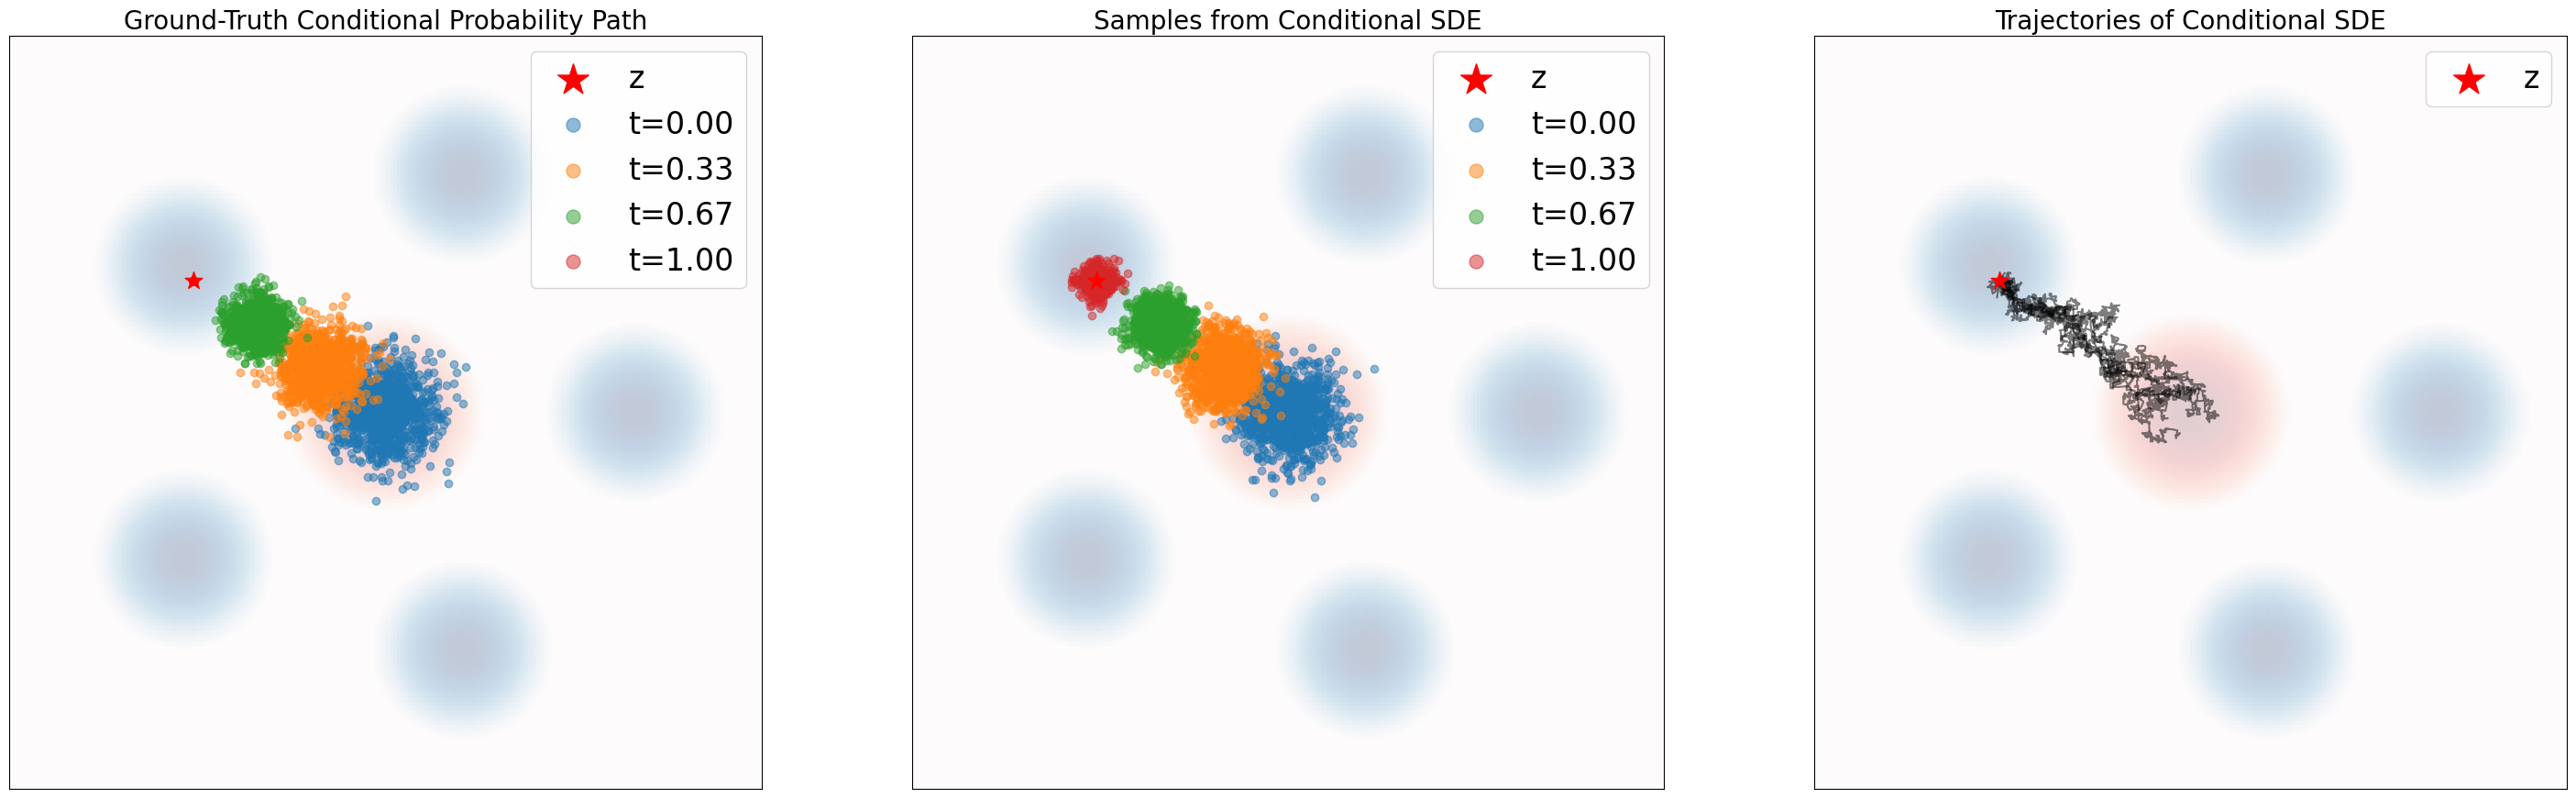

In [34]:
# Run me for Problem 2.3!

#######################
# Change these values #
#######################
num_samples = 1000
num_timesteps = 1000
num_marginals = 3
sigma = 2.5

########################
# Setup path and plot  #
########################

path = GaussianConditionalProbabilityPath(
    p_data = GaussianMixture.symmetric_2D(nmodes=5, std=PARAMS["target_std"], scale=PARAMS["target_scale"]).to(device), 
    alpha = LinearAlpha(),
    beta = SquareRootBeta()
).to(device)


# Setup figure
fig, axes = plt.subplots(1,3, figsize=(36, 12))
scale = PARAMS["scale"]
x_bounds = [-scale,scale]
y_bounds = [-scale,scale]
legend_size = 24
markerscale = 1.8

# Sample conditioning variable z
torch.cuda.manual_seed(1)
z = path.sample_conditioning_variable(1) # (1,2)

######################################
# Graph Samples from Conditional SDE #
######################################
ax = axes[1]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Samples from Conditional SDE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))


# Construct integrator and plot trajectories
sde = ConditionalVectorFieldSDE(path, z, sigma)
simulator = EulerMaruyamaSimulator(sde)
x0 = path.p_simple.sample(num_samples) # (num_samples, 2)
ts = torch.linspace(0.0, 1.0, num_timesteps).view(1,-1,1).expand(num_samples,-1,1).to(device) # (num_samples, nts, 1)
xts = simulator.simulate_with_trajectory(x0, ts) # (bs, nts, dim)

# Extract every n-th integration step to plot
every_n = record_every(num_timesteps=num_timesteps, record_every=num_timesteps // num_marginals)
xts_every_n = xts[:,every_n,:] # (bs, nts // n, dim)
ts_every_n = ts[0,every_n] # (nts // n,)
for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].item()
    ax.scatter(xts_every_n[:,plot_idx,0].detach().cpu(), xts_every_n[:,plot_idx,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt:.2f}')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


##########################################
# Graph Trajectories of Conditional SDE  #
##########################################
ax = axes[2]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Trajectories of Conditional SDE', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))

for traj_idx in range(5):
    ax.plot(xts[traj_idx,:,0].detach().cpu(), xts[traj_idx,:,1].detach().cpu(), alpha=0.5, color='black')
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)


###################################################
# Graph Ground-Truth Conditional Probability Path #
###################################################
ax = axes[0]

ax.set_xlim(*x_bounds)
ax.set_ylim(*y_bounds)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Ground-Truth Conditional Probability Path', fontsize=20)
ax.scatter(z[:,0].cpu(), z[:,1].cpu(), marker='*', color='red', s=200, label='z',zorder=20) # Plot z


for plot_idx in range(xts_every_n.shape[1]):
    tt = ts_every_n[plot_idx].unsqueeze(0).expand(num_samples, 1)
    zz = z.expand(num_samples, 2)
    marginal_samples = path.sample_conditional_path(zz, tt)
    ax.scatter(marginal_samples[:,0].detach().cpu(), marginal_samples[:,1].detach().cpu(), marker='o', alpha=0.5, label=f't={tt[0,0].item():.2f}')

# Plot source and target
imshow_density(density=p_simple, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Reds'))
imshow_density(density=p_data, x_bounds=x_bounds, y_bounds=y_bounds, bins=200, ax=ax, vmin=-10, alpha=0.25, cmap=plt.get_cmap('Blues'))
ax.legend(prop={'size': legend_size}, loc='upper right', markerscale=markerscale)

plt.show()

### Part 3: Flow Matching and Score Matching with Gaussian Conditional Probability Path